---
---

# Spaceship Titanic (kaggle competition)

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<div style='text-align: center;'>
    <img src='./imgs/spaceshipTitanic.jpg' alt='Spaceship Titanic' width='50%'/>
</div>

---
## Feature Information:

|Variable|Description|
|-|-|
|`PassengerId`|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always|
|`HomePlanet`|The planet the passenger departed from, typically their planet of permanent residence|
|`CryoSleep`|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins|
|`Cabin`|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard|
|`Destination`|The planet the passenger will be debarking to|
|`Age`|The age of the passenger|
|`VIP`|Whether the passenger has paid for special VIP service during the voyage|
|`RoomService`|Amount the passenger has billed for room service|
|`FoodCourt`|Amount the passenger has billed at the food court|
|`ShoppingMall`|Amount the passenger has billed at the shopping mall|
|`Spa`|Amount the passenger has blled at the spa|
|`VR Deck`|Amount the passenger has billed at the VR deck|
|`Name`|The first and last name of the passenger|
|`Transported`|Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict|
  
## Submission Info:

A submission file in the correct format:
 - `PassengerId`: Id for each passenger in the test set.
 - `Transported`: The target. For each passenger, predict either True or False.

## Metric Info:

Submissions are evaluated based on their classification accuracy, the percentage of predicted labels that are correct.

---
---
## Introduction

This notebook aims to:
1. Carry out a full EDA of the Spaceship Titanic train dataset
    - Univariate
    - Bivariate
    - Multivariate
2. Include relevant feature engineering
3. Develop machine learning models (with sklearn)
    - Classification algorithms
    - Try using VotingClassifier and StackingClassifier
4. Produce a valid submission for the kaggle competition

---
---
## Imports

In [1]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer, FunctionTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztoolz as viz
import mltoolz as mlt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

---

## Load Datasets

Separate train and test datasets provided

In [2]:
train = pd.read_csv('./data/raw/train.csv')
test = pd.read_csv('./data/raw/test.csv')

print('-'*16)
print(f'Train Set Shape:\n{train.shape}')
print('-'*16)
print(f'Test Set Shape:\n{test.shape}')
print('-'*16)

----------------
Train Set Shape:
(8693, 14)
----------------
Test Set Shape:
(4277, 13)
----------------


---
## Train Dataset Info Review:

In [3]:
mlt.describe_and_suggest(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns)
dtypes: object(7), float64(6), bool(1)
memory usage: 3461.6 KB

Total Percentage of Null Values: 26.73%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
PassengerId,object,8693,0,0.00,8693,100.00,Categorical
HomePlanet,object,8492,201,2.31,3,0.03,Categorical
CryoSleep,object,8476,217,2.50,2,0.02,Binary
Cabin,object,8494,199,2.29,6560,75.46,Categorical
Destination,object,8511,182,2.09,3,0.03,Categorical
Age,float64,8514,179,2.06,80,0.92,Numerical Discrete
VIP,object,8490,203,2.34,2,0.02,Binary
RoomService,float64,8512,181,2.08,1273,14.64,Numerical Continuous
FoodCourt,float64,8510,183,2.11,1507,17.34,Numerical Continuous
ShoppingMall,float64,8485,208,2.39,1115,12.83,Numerical Continuous


In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


---
---
## Imputation Strategy for NaN values

This is perhaps an overly complicated strategy for imputing NaN values. However, i want to use this project as an exercise to try out different ideas and methods that i have been learning and reading about.

- All columns except `PassengerId` and `Transported` have around 2% NaN values
- A full dropna() call is out of the question given that the total percentage of missing values is nearly 27%
- Need to devise a strategy to impute missing values in the test set that does not prejudice and predictions

I initially wanted to try a strategy that combines ordinal coding with KNN imputation, however there seem to be drawbacks and methodological flaws in this method. Namely, that assigining arbitrary oridnal values to categorical variables potentially implies relationships with other data that simply do not exist and therefore seems fundmentally incorrect.

### Idea for workflow:

***NOTE***: these ideas were discovered through EDA

- Use `PassengerId` to extract whether a passenger travelled in a group or not
- Assuming that people within the same group likely left/are from the same planet
    1. Impute `HomePlanet` NaNs based on travel groups
    2. `VIP` has very high percentage of people with `HomePlanet as 'Europa' so anyone with `VIP` = True, impute `HomePlanet` as 'Europa'
    3. Any remaining NaNs filled with modeal `HomePlanet`
- Bivariate analysis of Categorical columns with viz.categorical_relationships() to visualize relationship and calculate mutual_info_score.
- Impute proportionally based on categorical column with highest mutual info score (`HomePlanet` seemed to be strongest indicator for all other categorical columns)
- Use a function to carry out imputations
- Impute numerical columns NaN values using KNNImputer(n_neighbors=5)

In [5]:
mlt.describe_and_suggest(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns)
dtypes: object(7), float64(6), bool(1)
memory usage: 3461.6 KB

Total Percentage of Null Values: 26.73%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
PassengerId,object,8693,0,0.00,8693,100.00,Categorical
HomePlanet,object,8492,201,2.31,3,0.03,Categorical
CryoSleep,object,8476,217,2.50,2,0.02,Binary
Cabin,object,8494,199,2.29,6560,75.46,Categorical
Destination,object,8511,182,2.09,3,0.03,Categorical
Age,float64,8514,179,2.06,80,0.92,Numerical Discrete
VIP,object,8490,203,2.34,2,0.02,Binary
RoomService,float64,8512,181,2.08,1273,14.64,Numerical Continuous
FoodCourt,float64,8510,183,2.11,1507,17.34,Numerical Continuous
ShoppingMall,float64,8485,208,2.39,1115,12.83,Numerical Continuous


In [6]:
# Transform 'PassengerId' into some more useful variables
train['GroupId'] = train['PassengerId'].str.split('_').str[0]
train['PassengerNumber'] = train['PassengerId'].str.split('_').str[1].astype(float)

group_counts = train['GroupId'].value_counts()
train['GroupSize'] = train['GroupId'].map(group_counts)
train['InGroup'] = np.where(train['GroupSize'] > 1, 1, 0)

# Transform 'Cabin' into potentially more useful variables
train['Deck'] = train['Cabin'].str.split('/').str[0]
train['CabinNumber'] = train['Cabin'].str.split('/').str[1].astype(float)
train['Side'] = train['Cabin'].str.split('/').str[2]

bin_edges = np.linspace(train['CabinNumber'].min(), train['CabinNumber'].max(), 5)
train['CabinPosition'] = pd.cut(train['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)


# Fill NaNs im 'HomePlanet'
mode_by_group = train.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
train.loc[train['HomePlanet'].isna(), 'HomePlanet'] = mode_by_group[train['HomePlanet'].isna()]

mode_by_deck = train.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
train.loc[train['HomePlanet'].isna(), 'HomePlanet'] = mode_by_deck[train['HomePlanet'].isna()]

train.loc[train['VIP'] & train['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'

train['HomePlanet'].fillna(train.HomePlanet.mode()[0], inplace=True)

# Fill NaNs in other remaining categorical columns

# 1. Create function to fill based on proportionality of columns
# used viz.categorical relationships to decide which columns proportions had highest mutual info with given column
# Made function to proportionally impute NaNs
def proportional_imputer(df, groupby_col='', impute_col=''):
    proportions = df.groupby(groupby_col)[impute_col].value_counts(normalize=True)

    def impute_values(row):
        if pd.isna(row[impute_col]):
            group = row[groupby_col]
            if pd.notna(group) and group in proportions.index:
                group_proportions = proportions.loc[group].dropna()
                return np.random.choice(group_proportions.index, p=group_proportions.values)
        return row[impute_col]
    
    df[impute_col] = df.apply(impute_values, axis=1)
    return df

# For loop to cycle through remaining categorical columns
for col in ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']:
    train = proportional_imputer(train, groupby_col='HomePlanet', impute_col=col)

# Impute NaNs in numerical columns using KNN imputer (n_neighbors=5)
knnimputer_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
knn_imputer = KNNImputer(n_neighbors=5)
train[knnimputer_cols] = knn_imputer.fit_transform(train[knnimputer_cols])

# Create 'TotalSpent' column
train['TotalSpent'] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Drop unnecessary columns. Not really necessary as going to reorder columns
droppers = ['PassengerNumber','GroupId','Cabin','CabinNumber','Name']
train.drop(droppers, axis=1, inplace=True)

# Reorder dataframe for my own idosyncracies
ordered = ['PassengerId','HomePlanet','Destination','Deck','CabinPosition','Side','VIP','CryoSleep','InGroup','GroupSize','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent','Transported']
train = train[ordered]

---
## Recasting data types for binary features

- [`'InGroup'`, `'CryoSleep'`, `'VIP'`, `'Transported'`]

In [7]:
for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
    train[col] = train[col].astype(int)

# Done here as can't drop from X_test
# train.drop('PassengerId', axis=1, inplace=True)

# Check for complete imputation of NaNs and correct data types
info_df = mt.describe_and_suggest(train)
info_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns)
dtypes: float64(7), object(6), int64(5)
memory usage: 3568.5 KB

Total Percentage of Null Values: 0.00%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
PassengerId,object,8693,0,0.0,8693,100.00,Categorical
HomePlanet,object,8693,0,0.0,3,0.03,Categorical
Destination,object,8693,0,0.0,3,0.03,Categorical
Deck,object,8693,0,0.0,8,0.09,Categorical
CabinPosition,object,8693,0,0.0,4,0.05,Categorical
Side,object,8693,0,0.0,2,0.02,Binary
VIP,int64,8693,0,0.0,2,0.02,Binary
CryoSleep,int64,8693,0,0.0,2,0.02,Binary
InGroup,int64,8693,0,0.0,2,0.02,Binary
GroupSize,int64,8693,0,0.0,8,0.09,Categorical


---
### Applications of all transformations and imputations to test set

- If there are no issues then i will try to build this into a pipeline. 
- Unnecessary for this problem/project, but good practice.
- Pipelines possibly won't save much code as majority over processing has been done through functions which will have to be put into FunctionTransformers. However, it ensures unbiased assessment of validation fold in cross-validation. All steps will be executed in order for each fold.

In [8]:
test = test.copy()

# Transform 'PassengerId' into some more useful variables
test['GroupId'] = test['PassengerId'].str.split('_').str[0]
test['PassengerNumber'] = test['PassengerId'].str.split('_').str[1].astype(float)

group_counts = test['GroupId'].value_counts()
test['GroupSize'] = test['GroupId'].map(group_counts)
test['InGroup'] = np.where(test['GroupSize'] > 1, 1, 0)

# Transform 'Cabin' into potentially more useful variables
test['Deck'] = test['Cabin'].str.split('/').str[0]
test['CabinNumber'] = test['Cabin'].str.split('/').str[1].astype(float)
test['Side'] = test['Cabin'].str.split('/').str[2]

bin_edges = np.linspace(test['CabinNumber'].min(), test['CabinNumber'].max(), 5)
test['CabinPosition'] = pd.cut(test['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)

# Fill NaNs im 'HomePlanet'
mode_by_group = test.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
test.loc[test['HomePlanet'].isna(), 'HomePlanet'] = mode_by_group[test['HomePlanet'].isna()]

mode_by_deck = test.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
test.loc[test['HomePlanet'].isna(), 'HomePlanet'] = mode_by_deck[test['HomePlanet'].isna()]

test.loc[test['VIP'] & test['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'

test['HomePlanet'].fillna(test.HomePlanet.mode()[0], inplace=True)

# Fill NaNs in other remaining categorical columns

# 1. Create function to fill based on proportionality of columns
# used viz.categorical relationships to decide which columns proportions had highest mutual info with given column
# Made function to proportionally impute NaNs
def proportional_imputer(df, groupby_col='', impute_col=''):
    proportions = df.groupby(groupby_col)[impute_col].value_counts(normalize=True)

    def impute_values(row):
        if pd.isna(row[impute_col]):
            group = row[groupby_col]
            if pd.notna(group) and group in proportions.index:
                group_proportions = proportions.loc[group].dropna()
                return np.random.choice(group_proportions.index, p=group_proportions.values)
        return row[impute_col]
    
    df[impute_col] = df.apply(impute_values, axis=1)
    return df

# For loop to cycle through remaining categorical columns
for col in ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']:
    test = proportional_imputer(test, groupby_col='HomePlanet', impute_col=col)

# Impute NaNs in numerical columns using KNN imputer (n_neighbors=5)
knnimputer_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
knn_imputer = KNNImputer(n_neighbors=5)
test[knnimputer_cols] = knn_imputer.fit_transform(test[knnimputer_cols])

# Create 'TotalSpent' column
test['TotalSpent'] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Drop unnecessary columns
droppers = ['PassengerNumber','GroupId','Cabin','CabinNumber','Name']
test.drop(droppers, axis=1, inplace=True)

# Reorder dataframe for my own idosyncracies
ordered = ['PassengerId','HomePlanet','Destination','Deck','CabinPosition','Side','VIP','CryoSleep','InGroup','GroupSize','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']
test = test[ordered]

for col in ['InGroup', 'CryoSleep', 'VIP']:
    test[col] = test[col].astype(int)

X )

In [9]:
"""X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train))
oh_encoded = ohe.fit_transform(X_train[oh_cols])
X_train = pd.concat([X_train, oh_encoded], axis=1).drop(columns=oh_cols)"""

'X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])\nknn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train))\noh_encoded = ohe.fit_transform(X_train[oh_cols])\nX_train = pd.concat([X_train, oh_encoded], axis=1).drop(columns=oh_cols)'

---
---
## Train, validation split

In [10]:
target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)


---
---
## Exploratory Data Analysis of cleaned / imputed train set

In [11]:
cat_cols = info_df[info_df['Suggested Type'].isin(['Categorical','Binary'])].index.to_list()
num_cols = [col for col in train.columns if col not in cat_cols]
cat_cols.remove('Transported')

#### Target Analysis

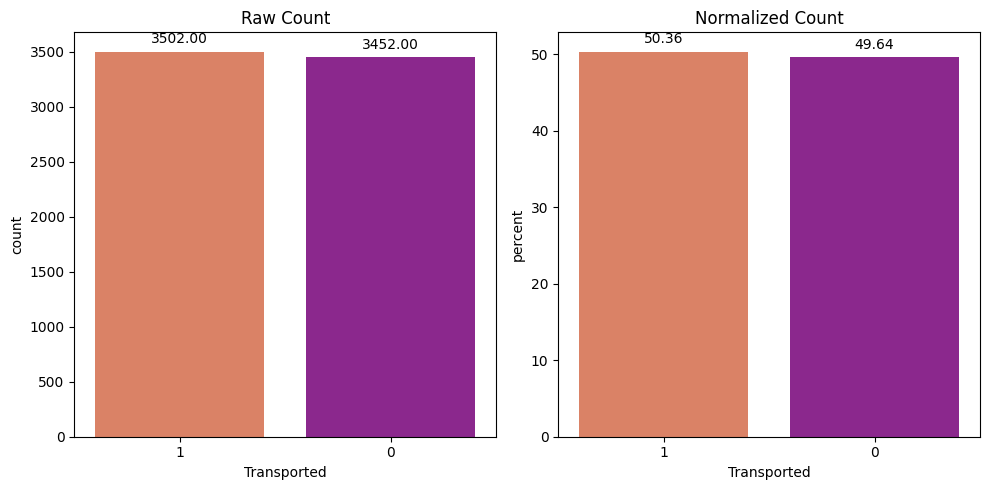

In [12]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
viz.countplot(train, target, stat='count', show_vals=True, ax=axes[0])
viz.countplot(train, target, stat='percent', show_vals=True, ax=axes[1])
axes[0].set_title('Raw Count')
axes[1].set_title('Normalized Count')
plt.tight_layout()
plt.show()

***Comments***:
- Very evenly distributed target classes with a near 50:50 split
- Makes model development more straightforward as no over / under sampling techniques will be required

---
### 1. Univariate Analysis

i) Categorical Features

In [1]:
fig, axes = plt.subplots(len(cat_cols), 2, figsize=(10, 5 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    viz.countplot(train, col, stat='count', show_vals=True, ax=axes[i][0])
    axes[i][0].set_title(f'Raw Count for {col}')
    viz.countplot(train, col, stat='percent', show_vals=True, ax=axes[i][1])
    axes[i][1].set_title(f'Normalized Count for {col}')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

***Comments / Insights***:

- 
- 


---
ii) Numerical Features

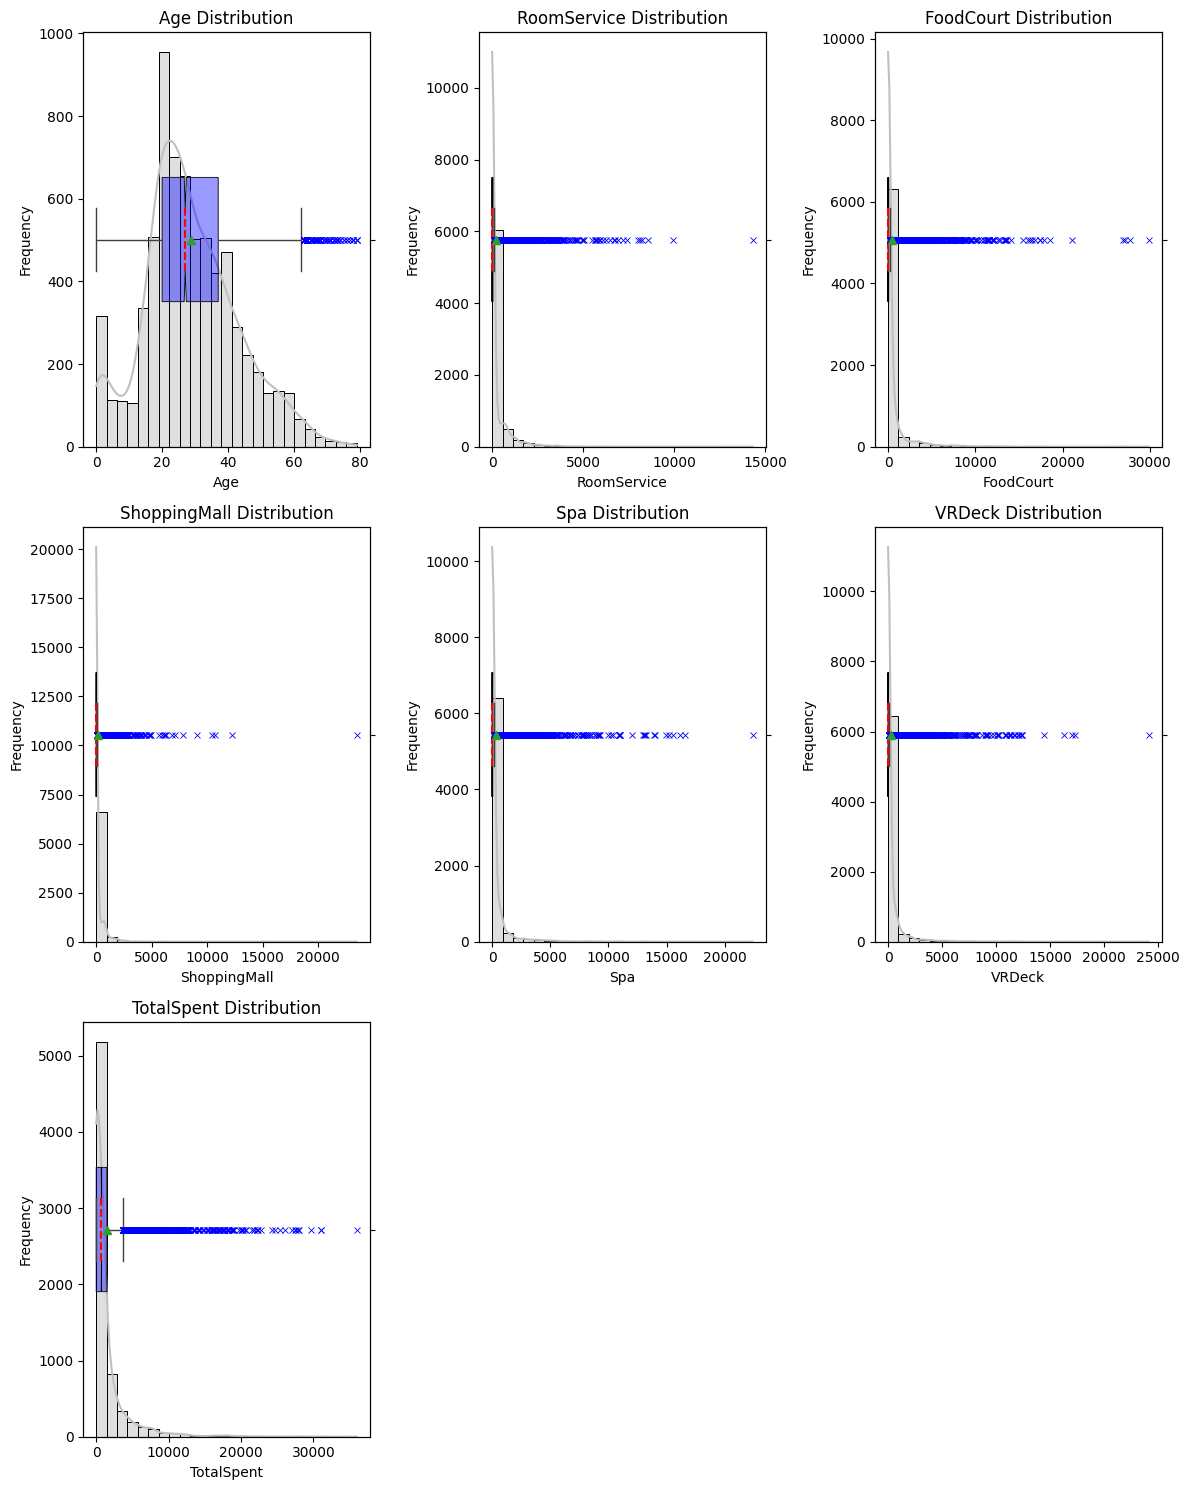

In [14]:
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    viz.histobox2(train, col, ax=axes[i], kde=True)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

***Comments / Insights***:

- 
- 


---
---
## Model Selection

Going to build models based on the following algorithms:
- Logisitic Regression
- Random Forest Classifier
- LightGBM Classifier
- XGBM Classifier
- Catboost Classifier

I will also experiment with:
- Voting classifiers
- Stacking Classifiers
- Combinations of voting and stacking classifiers built from combinations of above models

In [15]:
# The following variables will be used in the final pipelines
proportional_impute_cols = ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']
knnimputer_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
ohe_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition']
scaler_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']
polynomial_feats = ['TotalSpent']

In [16]:
lr = LogisticRegression(C=1)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
xgbm = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
catb = CatBoostClassifier(iterations=100, depth=5, cat_features=ohe_cols, l2_leaf_reg=2)
svm = SVC(C=1, kernel='sigmoid', gamma='scale')

models = {'lr':lr, 'rf':rf, 'lgbm':lgbm, 'xgbm':xgbm, 'catb':catb}

---
---
## Pipeline

1. Create functions for use with FunctionTransformers

In [17]:
# Transform 'PassengerId'
def transform_passengerId(df):
    df['GroupId'] = df['PassengerId'].str.split('_').str[0]
    df['PassengerNumber'] = df['PassengerId'].str.split('_').str[1].astype(float)
    group_counts = df['GroupId'].value_counts()
    df['GroupSize'] = df['GroupId'].map(group_counts)
    df['InGroup'] = np.where(df['GroupSize'] > 1, 1, 0)
    return df

# Transform 'Cabin'
def transform_Cabin(df):
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Side'] = df['Cabin'].str.split('/').str[2]
    bin_edges = np.linspace(df['CabinNumber'].min(), df['CabinNumber'].max(), 5)
    df['CabinPosition'] = pd.cut(df['CabinNumber'],
                                 bins=bin_edges,
                                 labels=['Front','Second','Third','Back'],
                                 include_lowest=True)
    return df

# Imputations for NaNs in 'HomePlanet'
def impute_homePlanet(df):
    group_modes = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = group_modes[df['HomePlanet'].isna()]

    deck_modes = df.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[df['HomePlanet'].isna()]

    vip_mode_homePlanet = df.loc[df['VIP'] == True, 'HomePlanet'].mode().iloc[0]
    df.loc[df['VIP'] & df['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

    df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0], inplace=True)

    return df

# Create a proportional imputer
def proportional_imputer(df, impute_cols):
    for col in impute_cols:
        proportions = df.groupby('HomePlanet')[col].value_counts(normalize=True)

        def impute_values(row):
            if pd.isna(row[col]):
                group = row['HomePlanet']
                if pd.notna(group) and group in proportions.index:
                    group_proportions = proportions.loc[group].dropna()
                    return np.random.choice(group_proportions.index, p=group_proportions.values)
                return row[col]
            
        df[col] = df.apply(impute_values, axis=1)
    return df

# Create a 'TotalSPent' feature
def create_totalSpent(df):
    df['TotalSpent'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
    return df

# Convert data types
def convert_to_int(df):
    for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
        if col in df.columns:
            df[col] = df[col].astype(int)
    return df

2. Created a basic idea for the general pipeline

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('transform_passengerId', FunctionTransformer(transform_passengerId), ['PassengerId']),
        ('cabin_transformer', FunctionTransformer(transform_Cabin), ['Cabin']),
        ('homeplanet_imputer', FunctionTransformer(impute_homePlanet), ['HomePlanet']),
        ('proportional_imputer', FunctionTransformer(proportional_imputer, kw_args={'columns':proportional_impute_cols}), proportional_impute_cols),
        ('knn_imputer', KNNImputer(n_neighbors=5), knnimputer_cols)],
        remainder = 'passthrough')

manipulator = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
        ('scale', StandardScaler(), scaler_cols)],
        remainder = 'passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('create_totalSpent', FunctionTransformer(create_totalSpent)),
    ('dtype_conversions', FunctionTransformer(convert_to_int)),
    ('drop_cols', FunctionTransformer(lambda df: df.drop(['PassengerNumber','GroupId','Cabin','CabinNumber','Name'], axis=1, errors='ignore'))),
    ('manipulate', manipulator),
    ])

3. Created a function to differentially select / add pipeline elements depending on the model being added to the pipeline

In [19]:
def get_pipeline(models):

    pipelines = {}

    for name, model in models.items():

        if model.__class__.__name__ in ['LogisticRegression', 'SVC']:
            manipulator = ColumnTransformer(
                transformers=[
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
                ('transform_distribution', PowerTransformer(method='yeo-johnson'), scaler_cols),
                ('scale', StandardScaler(), scaler_cols),
                ('polynomials', PolynomialFeatures(degree=2, include_bias=False), polynomial_feats)],
                remainder = 'passthrough')

        elif model.__class__.__name__ == 'CatBoostClassifier':
            manipulator = ColumnTransformer(
                transformers=[
                    ('scale', StandardScaler(), scaler_cols)])
            
        else:
            manipulator = manipulator

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('create_totalSpent', FunctionTransformer(create_totalSpent)),
            ('dtype_conversions', FunctionTransformer(convert_to_int)),
            ('drop_cols', FunctionTransformer(lambda df: df.drop(['PassengerNumber','GroupId','Cabin','CabinNumber','Name'], axis=1, errors='ignore'))),
            ('manipulate', manipulator),
            ('model', model)
            ])
        
        pipelines[name] = pipeline

    return pipelines

In [20]:
pipelines = get_pipeline(models)

In [22]:
X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [23]:
pipelines['lr'].fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe